In [1]:
import pandas as pd
import io

# --- 1. Load Data ---

# Specify the file path
file_path = 'Adapted_Dataset.csv'

# Load CSV, setting the correct separator (;) and decimal (,)
try:
    df_raw = pd.read_csv(file_path, sep=';', decimal=',')
    print("File loaded successfully.")
    print(f"Total rows: {df_raw.shape[0]}, Total columns: {df_raw.shape[1]}")
except FileNotFoundError:
    print(f"Error: The file {file_path} was not found.")
    
# Display the first 3 rows to check
print(df_raw.head(3))

File loaded successfully.
Total rows: 50401, Total columns: 300
          utc_timestamp        cet_cest_timestamp  \
0  2014-12-31T23:00:00Z  2015-01-01T00:00:00+0100   
1  2015-01-01T00:00:00Z  2015-01-01T01:00:00+0100   
2  2015-01-01T01:00:00Z  2015-01-01T02:00:00+0100   

   AT_load_actual_entsoe_transparency  AT_load_forecast_entsoe_transparency  \
0                                 NaN                                   NaN   
1                              5946.0                                6701.0   
2                              5726.0                                6593.0   

   AT_price_day_ahead  AT_solar_generation_actual  \
0                 NaN                         NaN   
1                35.0                         NaN   
2                45.0                         NaN   

   AT_wind_onshore_generation_actual  BE_load_actual_entsoe_transparency  \
0                                NaN                                 NaN   
1                               69.0     

In [2]:
# --- 2. Process Datetime Column ---

# Convert 'cet_cest_timestamp' to a standardized UTC datetime object
df_raw['datetime'] = pd.to_datetime(df_raw['cet_cest_timestamp'], utc=True, errors='coerce')

# Set the new datetime column as the index (required for time-series operations)
df_raw.set_index('datetime', inplace=True)

# Drop original unneeded timestamp columns
df_raw.drop(['utc_timestamp', 'cet_cest_timestamp'], axis=1, inplace=True)

# Display the head to confirm the new index
print("DataFrame with datetime index:")
print(df_raw.head(3))

DataFrame with datetime index:
                           AT_load_actual_entsoe_transparency  \
datetime                                                        
2014-12-31 23:00:00+00:00                                 NaN   
2015-01-01 00:00:00+00:00                              5946.0   
2015-01-01 01:00:00+00:00                              5726.0   

                           AT_load_forecast_entsoe_transparency  \
datetime                                                          
2014-12-31 23:00:00+00:00                                   NaN   
2015-01-01 00:00:00+00:00                                6701.0   
2015-01-01 01:00:00+00:00                                6593.0   

                           AT_price_day_ahead  AT_solar_generation_actual  \
datetime                                                                    
2014-12-31 23:00:00+00:00                 NaN                         NaN   
2015-01-01 00:00:00+00:00                35.0                         NaN   

In [3]:
# --- 3. Select Project-Specific Columns (Corrected) ---

# Define the 7 countries for our project scope
final_7_countries = ['AT', 'DE', 'ES', 'FR', 'DK', 'GR', 'RO']
print(f"Project countries selected: {final_7_countries}")

columns_to_keep = []
for country in final_7_countries:
    # Add Load column
    columns_to_keep.append(f"{country}_load_actual_entsoe_transparency")
    
    # Add Solar column
    columns_to_keep.append(f"{country}_solar_generation_actual")
    
    # Add Wind column (handle specific column names for DE, DK)
    if country in ['DE', 'DK']: 
        # Germany and Denmark use the 'total' wind column
        columns_to_keep.append(f"{country}_wind_generation_actual")
    else:
        # All other countries use the 'onshore' wind column
        columns_to_keep.append(f"{country}_wind_onshore_generation_actual")

print(f"Total columns selected: {len(columns_to_keep)}")

# Create the final project DataFrame
df_project = df_raw[columns_to_keep].copy()

# Display the head of the new DataFrame
print("\n--- Project-specific DataFrame ---")
print(df_project.head())

Project countries selected: ['AT', 'DE', 'ES', 'FR', 'DK', 'GR', 'RO']
Total columns selected: 21

--- Project-specific DataFrame ---
                           AT_load_actual_entsoe_transparency  \
datetime                                                        
2014-12-31 23:00:00+00:00                                 NaN   
2015-01-01 00:00:00+00:00                              5946.0   
2015-01-01 01:00:00+00:00                              5726.0   
2015-01-01 02:00:00+00:00                              5347.0   
2015-01-01 03:00:00+00:00                              5249.0   

                           AT_solar_generation_actual  \
datetime                                                
2014-12-31 23:00:00+00:00                         NaN   
2015-01-01 00:00:00+00:00                         NaN   
2015-01-01 01:00:00+00:00                         NaN   
2015-01-01 02:00:00+00:00                         NaN   
2015-01-01 03:00:00+00:00                         NaN   

          

In [4]:
# --- 4. Analyze Missing Values (NaN) ---
# Check the data quality of the selected 21 columns.
# Expected all columns to be < 1% missing data.

# Calculate the total number of missing values for each column
missing_values_count = df_project.isnull().sum()

# Calculate the percentage of missing values
total_rows = len(df_project)
missing_values_percent = (missing_values_count / total_rows) * 100

# Combine the counts and percentages into a new DataFrame for easy reading
missing_info = pd.DataFrame({
    'Missing_Count': missing_values_count,
    'Missing_Percent': missing_values_percent
})

# Sort by percentage descending to see the worst columns first
print("--- Missing Value Report ---")
print(missing_info.sort_values(by='Missing_Percent', ascending=False))

--- Missing Value Report ---
                                    Missing_Count  Missing_Percent
RO_solar_generation_actual                    132         0.261900
RO_load_actual_entsoe_transparency            125         0.248011
RO_wind_onshore_generation_actual             116         0.230154
DE_solar_generation_actual                    104         0.206345
DE_wind_generation_actual                      75         0.148807
AT_solar_generation_actual                     62         0.123013
AT_wind_onshore_generation_actual              49         0.097220
GR_solar_generation_actual                     48         0.095236
FR_load_actual_entsoe_transparency             44         0.087300
GR_load_actual_entsoe_transparency             38         0.075395
GR_wind_onshore_generation_actual              36         0.071427
ES_load_actual_entsoe_transparency             23         0.045634
ES_solar_generation_actual                     17         0.033729
ES_wind_onshore_generation_actual

In [5]:
# --- 5. Handle Missing Values (NaN) ---

# Fill the few remaining gaps (<1%) using time-based interpolation
df_project_cleaned = df_project.interpolate(method='time')
# Drop any remaining NaNs (e.g., at the very start of the dataset)
df_project_cleaned = df_project_cleaned.dropna()

# --- Final Check ---
print("\n--- FINAL CLEANING REPORT ---")
print(f"Original row count: {len(df_project)}")
print(f"Cleaned row count: {len(df_project_cleaned)}")
print(f"Remaining NaN values: {df_project_cleaned.isnull().sum().sum()}")


--- FINAL CLEANING REPORT ---
Original row count: 50401
Cleaned row count: 50282
Remaining NaN values: 0


Plotting comparison graph...


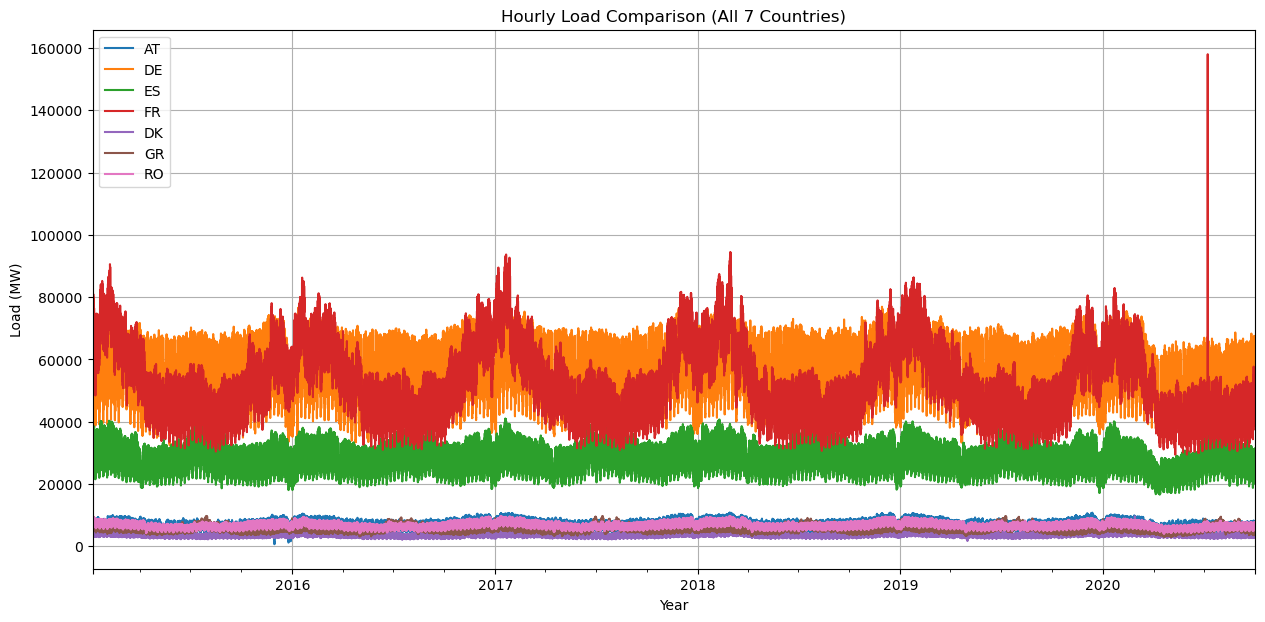

In [6]:
import matplotlib.pyplot as plt

# --- 6. Quick Visualization (All 7 Countries) ---

print("Plotting comparison graph...")
plt.figure(figsize=(15, 7))

# Loop through countries and plot their 'load'
for country_code in final_7_countries:
    col_name = f"{country_code}_load_actual_entsoe_transparency"
    df_project_cleaned[col_name].plot(label=country_code) # Add label for legend

plt.title('Hourly Load Comparison (All 7 Countries)')
plt.ylabel('Load (MW)')
plt.xlabel('Year')
plt.grid(True)
plt.legend() # Show legend
plt.show()

Found 1 unrealistic data spikes for France.
Outlier spike(s) have been replaced via interpolation.
Plotting graph again to confirm the fix...


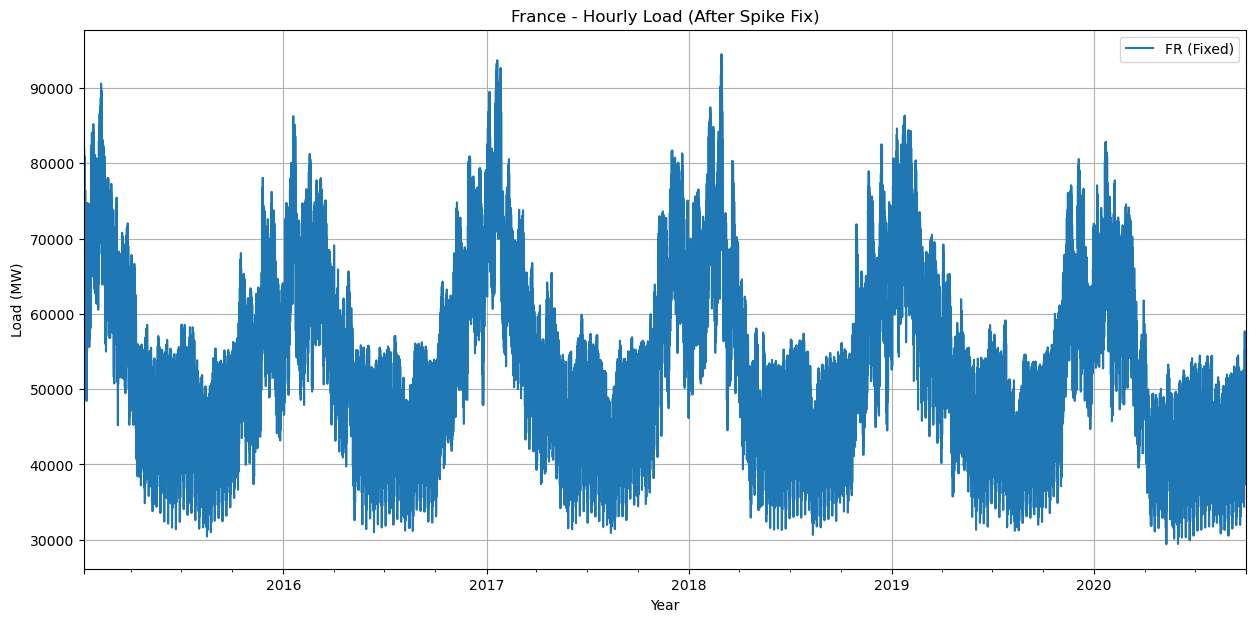

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# --- 6.5 (Corrected Fix) - Handle FR Outlier Spike ---

# We identified an unrealistic SPIKE in the French load data (FR_load)
fr_load_col = 'FR_load_actual_entsoe_transparency'

# A realistic maximum load for France is < 110,000 MW.
# We set a threshold at 120,000 MW to safely catch this error.
unrealistic_spikes = df_project_cleaned[fr_load_col] > 120000

print(f"Found {unrealistic_spikes.sum()} unrealistic data spikes for France.")

# Replace these outlier values with 'NaN' 
df_project_cleaned.loc[unrealistic_spikes, fr_load_col] = np.nan

# Now, we re-interpolate to fill the 'NaN' we just created.
df_project_cleaned = df_project_cleaned.interpolate(method='time')

print("Outlier spike(s) have been replaced via interpolation.")

# Re-Plotting to Confirm 
print("Plotting graph again to confirm the fix...")
plt.figure(figsize=(15, 7))

# Plot just France to see the fix clearly
df_project_cleaned[fr_load_col].plot(label='FR (Fixed)')

plt.title('France - Hourly Load (After Spike Fix)')
plt.ylabel('Load (MW)')
plt.xlabel('Year')
plt.grid(True)
plt.legend()
plt.show()

In [8]:
# --- 7. Feature Engineering ---

# Create a new DataFrame for our features and targets
# We start by copying the clean data
df_model = df_project_cleaned.copy()

# Create time-based features from the DataFrame's index
# The index is a 'datetime' object, so we can access its properties
df_model['hour'] = df_model.index.hour
df_model['day_of_week'] = df_model.index.dayofweek # Monday=0, Sunday=6 for example
df_model['month'] = df_model.index.month
df_model['year'] = df_model.index.year

# Display the head to see the new columns
print("--- DataFrame with new Time Features ---")
print(df_model.head())

# Display the tail as well, just to be sure
print("\n--- DataFrame Tail ---")
print(df_model.tail())

--- DataFrame with new Time Features ---
                           AT_load_actual_entsoe_transparency  \
datetime                                                        
2015-01-05 22:00:00+00:00                              6182.0   
2015-01-05 23:00:00+00:00                              5523.0   
2015-01-06 00:00:00+00:00                              5220.0   
2015-01-06 01:00:00+00:00                              5015.0   
2015-01-06 02:00:00+00:00                              4868.0   

                           AT_solar_generation_actual  \
datetime                                                
2015-01-05 22:00:00+00:00                         0.0   
2015-01-05 23:00:00+00:00                         0.0   
2015-01-06 00:00:00+00:00                         0.0   
2015-01-06 01:00:00+00:00                         0.0   
2015-01-06 02:00:00+00:00                         0.0   

                           AT_wind_onshore_generation_actual  \
datetime                               

In [9]:
# --- 7.5 Save Cleaned Data (Checkpoint) ---

# Save in 'parquet' format. 
# It's very fast and preserves our datetime index and data types.

output_filename_parquet = 'df_model_cleaned.parquet'

try:
    df_model.to_parquet(output_filename_parquet, engine='pyarrow')
    print(f"Data successfully saved to: {output_filename_parquet}")
    print("If you restart your notebook, you can load this file.")

except ImportError:
    print("Note: 'pyarrow' (for parquet) not found.")
    print("Saving to .pkl (Pickle) format instead.")
    
    output_filename_pkl = 'df_model_cleaned.pkl'
    df_model.to_pickle(output_filename_pkl)
    print(f"Data successfully saved to: {output_filename_pkl}")

Data successfully saved to: df_model_cleaned.parquet
If you restart your notebook, you can load this file.
